In [1]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import re
from textblob import TextBlob

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess
pyLDAvis.enable_notebook()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

from wordcloud import WordCloud

## Clean Huge Df

In [2]:
from google.cloud import storage
import os
import io
client = storage.Client()
bucket = client.get_bucket('nlp_final_data')

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 16


In [4]:
#! pip install pandarallel
import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [49]:
blob = bucket.blob('song_lyrics.csv')
content = blob.download_as_string()

songs = pd.read_csv(io.BytesIO(content))

In [50]:
songs.columns

Index(['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id',
       'language_cld3', 'language_ft', 'language'],
      dtype='object')

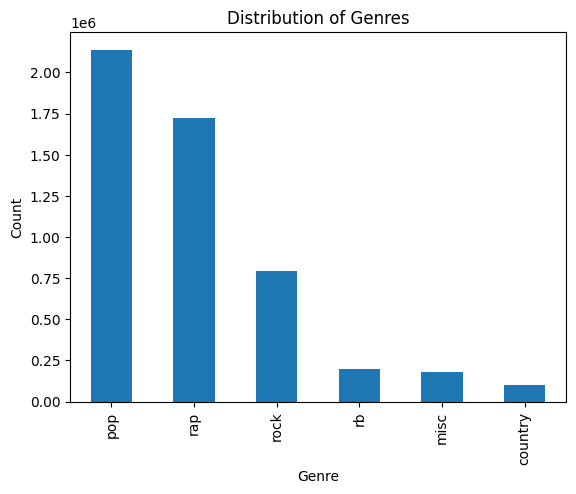

In [51]:
# Plot value counts as a bar plot
songs['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

# Display the plot
plt.show()

In [8]:
len(songs)

5134856

## Most Listened to Songs

In [9]:
songs.sort_values(by=['views'],ascending=False)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
2029340,Despacito Remix,pop,Luis Fonsi & Daddy Yankee,2017,23351415,"{""Justin Bieber""}","[Letra de ""Despacito (Remix)"" ft. Justin Bieber]\n\n[Intro: Justin Bieber]\nComin' over in my direction\nSo thankful for that, it's such a blessin', yeah\nTurn every situation into heaven, yeah\nOh-oh, you are\nMy sunrise on the darkest day\nGot me feelin' some kind of way\nMake me wanna savor every moment slowly, slowly\nYou fit me tailor-made, love how you put it on\nGot the only key, know how to turn it on\nThe way you nibble on my ear, the only words I wanna hear\nBaby, take it slow so w...",3057010,es,es,es
212889,Rap God,rap,Eminem,2013,17575634,{},"[Intro]\n""Look, I was gonna go easy on you not to hurt your feelings""\n""But I'm only going to get this one chance"" (Six minutes— Six minutes—)\n""Something's wrong, I can feel it"" (Six minutes, Slim Shady, you're on!)\n""Just a feeling I've got, like something's about to happen, but I don't know what. \nIf that means what I think it means, we're in trouble, big trouble; \nAnd if he is as bananas as you say, I'm not taking any chances""\n""You are just what the doc ordered""\n\n[Chorus]\nI'm begin...",235729,en,en,en
3858378,WAP,rap,Cardi B,2020,16003444,"{""Megan Thee Stallion""}","[Intro: Cardi B, Al ""T"" McLaran & Megan Thee Stallion]\nWhores in this house\nThere's some whores in this house\nThere's some whores in this house\nThere's some whores in this house (Hol' up)\nI said certified freak, seven days a week\nWet-ass pussy, make that pullout game weak, woo (Ah)\n\n[Chorus: Cardi B]\nYeah, yeah, yeah, yeah\nYeah, you fuckin' with some wet-ass pussy\nBring a bucket and a mop for this wet-ass pussy\nGive me everything you got for this wet-ass pussy\n\n[Verse 1: Cardi ...",5832126,en,en,en
1950930,Shape of You,pop,Ed Sheeran,2017,14569727,{},"[Verse 1]\nThe club isn't the best place to find a lover\nSo the bar is where I go\nMe and my friends at the table doing shots\nDrinking fast and then we talk slow\nAnd you come over and start up a conversation with just me\nAnd trust me I'll give it a chance now\nTake my hand, stop, put Van the Man on the jukebox\nAnd then we start to dance, and now I'm singing like\n\n[Pre-Chorus]\nGirl, you know I want your love\nYour love was handmade for somebody like me\nCome on now, follow my lead\nI ...",2949128,en,en,en
2015234,HUMBLE.,rap,Kendrick Lamar,2017,11181199,{},"[Intro]\nNobody pray for me\nIt been that day for me\nWay (Yeah, yeah)\n\n[Verse 1]\nAyy, I remember syrup sandwiches and crime allowances\nFinesse a nigga with some counterfeits, but now I'm countin’ this\nParmesan where my accountant lives, in fact, I'm downin' this\nD’USSÉ with my boo bae, tastes like Kool-Aid for the analysts\nGirl, I can buy your ass the world with my paystub\nOoh, that pussy good, won't you sit it on my taste bloods?\nI get way too petty once you let me do the extras\n...",3039923,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
4935294,Let Them See,rock,Tendon Levey,2009,0,{},Let them see\n(Let the soldiers have good fun)\nLet them see\n(Let the soldiers have good fun)\nLet them see\n(Let the soldiers have good fun)\nLet them see\n(Let the soldiers have good fun)\n\nLet them see\n(Let the soldiers have good fun)\nLet them see\n(Let the soldiers have good fun)\nLet them see\n(Let the soldiers have good fun)\nLеt them see\n(Let the soldiеrs have good fun),7528903,en,en,en
417913,Past Liiife Shit Some Thought,misc,GiiibbZ Of Fizix,2015,0,{},"[Message: GiiibbZ Of Fizix]\nIn A Past Life ;\nI Was A Zombie Moon...\nInterim Galactica\nFar Away...\nUndead Shining...Shining...Shining...Shining\n\n[Reminiscent Words: GiiibbZ Of Fizix]\nIn A Past Life I Was A Young Dragon From The Gloom\nAnd In Another Packed Pills,Dissolve A Mother's Womb\nAn Avid Grave Robber Looting Scrolls In The Tomb\n- A Witch Doctor ; Headless Chicken On Brooms\nIn Another Faded Graffiti Who Preached, "" 

## Get rid of Duplicates

In [10]:
songs_new = songs.drop_duplicates(subset = ['title','artist'])

In [11]:
len(songs_new)

5134845

## Get Only English Songs

In [12]:
songs_eng = songs_new[songs_new.language=='en']

In [13]:
len(songs_eng)

3374188

## Get Rid of Misc Genre

In [14]:
songs_noMIsc = songs_eng[songs_eng.tag!='misc']

In [15]:
len(songs_noMIsc)

3233202

## Look at artists

In [16]:
songs_noMIsc.artist.value_counts()[:20]

Genius English Translations    13591
The Grateful Dead               2108
Lil B                           1306
Gucci Mane                      1239
Frank Zappa                     1232
Lil Wayne                       1208
KIDZ BOP Kids                   1199
Guided by Voices                1188
Tendon Levey                    1183
Juice WRLD                      1167
Frank Sinatra                   1068
Johnny Cash                     1041
Muze Sikk                        967
Madonna                          958
Willie Nelson                    951
Chief Keef                       924
OCTOBERSFULLMOON                 922
YOUNG DIAMOND                    896
Bob Dylan                        881
The Rolling Stones               855
Name: artist, dtype: int64

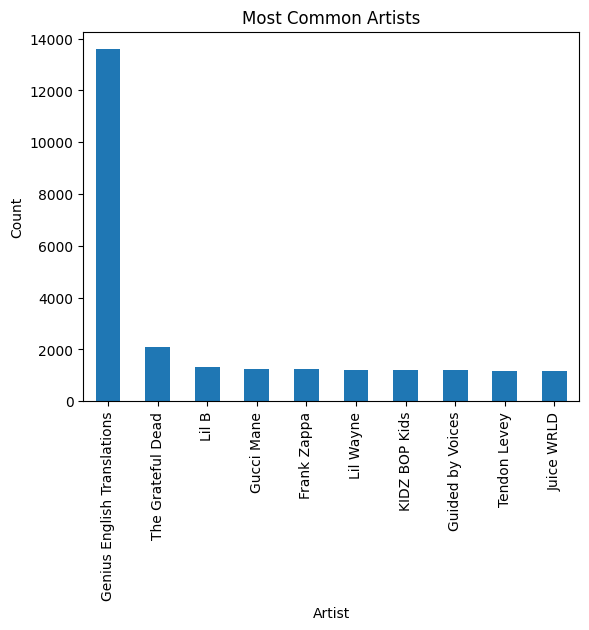

In [53]:
# Plot value counts as a bar plot
songs_noMIsc.artist.value_counts()[:10].plot(kind='bar')

# Set plot title and axis labels
plt.title('Most Common Artists')
plt.xlabel('Artist')
plt.ylabel('Count')

# Display the plot
plt.show()

In [18]:
songs_noMIsc[songs_noMIsc.artist=='Gucci Mane']

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
28,Colors,rap,Gucci Mane,2008,34914,{},[Verse 1]\nBlue and white Charger\nSame color the Dodgers\nCrayola car same color as a marker\nRed '74 same color as a Cardinal\nFat bank rolls like I robbed Wells Fargo\nBlack Bentley coupe same color as some charcoal\nClear through top same color as a dope boy\nOff-white Jag same color as the yayo\nPure white guts same color as some mayo\nTransformer Benz Decepticon like Legos\nSixes got my donk sitting like a Winnebago\nPaint like Play-Doh\nThe alfredo Lambo\nThe shrimp scampi Chevy and t...,21,en,en,en
314,Lemonade,rap,Gucci Mane,2009,448340,{},"[Intro: Gucci Mane]\nYeah, it's Gucci, what's up, baby? (Brr)\nYellow everything this time (Yellow), you know what I'm talking about?\nYellow rims (Lemons)\nYellow big booty yellowbones, ha (Yellow?)\nYellow Lambs (Yellow), yellow MPs (Yellow), yellow watch (Banana)\nYellow charm ring, chain (Yellow)\nYellow living room set (Chiquita, yellow)\nLemonade Gucci shoes for my girl (It's Gucci), it's Gucci\n\n[Verse 1: Gucci Mane]\nMy Phantom sitting on sixes, no twenties in my denim (No)\nYour Cu...",293,en,en,en
360,Bingo,rap,Gucci Mane,2010,16293,"{""Waka Flocka Flame"",""Soulja Boy""}","[Intro: Gucci Mane, Soulja Boy & Waka Flocka Flame]\nIt's Gucci, Burr! (Soulja Boy Tell'Em)\nIt's Gucci (Flocka!)\nScott Storch, Gucci Mane; We back at it\nBurr! So icey (Yeah!)\n\n[Chorus Gucci Mane]\nWe smoking that fire endo\nWrist out the damn window\nLambo, they scream ""Bingo!""\nEnzo, they scream ""Bingo!""\nPhantom, they scream ""Bingo!""\nConcept, they scream ""Bingo!""\nPull up, kid scream ""Bingo!""\nYour ma would scream: ""Bingo!""\n\n[Post-Chorus: Gucci Mane]\nBingo, Bingo, Bingo, Bingo!\nB...",356,en,en,en
361,Volume,rap,Gucci Mane,2009,9414,"{""Wooh da Kid""}","[Hook]\nI'm so motherfuckin' turned up right now\nSomeone please turn Gucci Mane down\nBrick Squad thugged out, we don't give a fuck\nWe hit the club, shoot the club, tear the club up\nSo you should hit the floor. Get low and shut up\nHit the floor, get low and shut the fuck up\nYou's a bitch, you's a snitch, you a motherfuckin' scrub\nYou's a bitch, you's a snitch, you a motherfuckin' scrub\n\n[Verse 1 - Gucci Mane]\nI pulled up in a 4-door Porsche, set-trippin'\n3 young dreadhead niggas ri...",357,en,en,en
364,Gingerbread Man,rap,Gucci Mane,2009,7198,"{""OJ da Juiceman""}","[Verse 1: Gucci Mane]\nI'mma keep dropping verses\nHotter than the hottest summer\nEat rappers like Jeffrey Dahmer\nDope color Sinead O'Connor\nShould I name another one\nUnless you like President Obama\nWanna buy two extra commas?\nAll my shoes are Ferragamo\nLightning actually hear the thunder\nEven Stevie Wonder wonder\nWhy yo baby mama call so much I had to change my number\nSarcasm, these bitches need to ride or ride past him\nI wouldn't even give that bitch an orgasm\nMiraculously my n...",360,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
4916544,Nose Red,rap,Gucci Mane,2021,650,{},"[Intro]\nDamn (J. White, I need a beat I can go off on, ooh)\n\n[Verse]\nBeam on your nose like Rudolph\nKeep a bomb on me like Eric Rudolph\nLike a dog on mute, got the roof off\nAnd like the Super Bowl, I take a nigga roof off\nGot a good fight game we can duke out\nA nigga touch Gucci Mane, that's a shootout\nI'ma take your name off, no white out\nIt be a dark day in hell like a light out\nYou dumb as hell tryin wop, shot out\nGot dummies tryna crash like Lunch pass\nYou a spirit from the...",7498003,en,en,en
4950743,Fake Friends,rap,Gucci Mane,2022,1389,{},"[Intro]\nYou know it's family first off top, and blood is thicker than water\nAnd there's no friend indeed like a friend in need (Why?)\nBut there's one thing you gotta watch and that's a friend in greed (Why?)\nLil' Ice you one years old right now, it's time that you learn more about your pops\nI know you was born rich and you the baby CEO (For sure)\nBut know one think, you gotta know

## Get rid of Kidz Bop Kids and Genius English Translations because they are not individual artists

In [19]:
songs_new = songs_noMIsc[songs_noMIsc.artist!='Genius English Translations']

In [20]:
songs_new = songs_new[songs_new.artist!='KIDZ BOP Kids ']

## Get rid of songs that are not listened to very often

In [25]:
songs_new.views.describe()

count    1.909850e+06
mean     5.342698e+03
std      6.951701e+04
min      0.000000e+00
25%      4.200000e+01
50%      1.840000e+02
75%      8.590000e+02
max      1.757563e+07
Name: views, dtype: float64

In [26]:
songs_new[songs_new.views<20]

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
16871,Dont Get it Curled,rap,Dom Pachino,2006,19,{},"[Intro: Dom Pachino]\nYeah, take a walk with me real quick, man\nShow you where I come from, how I ride\nWho I rock with, the Team, the camp, real shit\nReal street shit, man, come on, yo\n\n[Chorus: Dom Pachino]\nDon't get it curled, my shit off the chain\nI hear the shit that's out and that's the reason why I came\nDom P's the name, the game done changed\nI did my research and these niggas all lame\n\n[Dom Pachino]\nKeep my hat low, take the game to another plateau\nHe's so militant, regga...",17671,en,en,en
43293,Blunted Freestyle 4,rap,The Tongue,2011,9,{},"Bringing it back today like it was back in the day\nI'm prettier than the ash in your tray\nI'm stubbing it out, check the freestyle shit yo I'm running with now\nIn the club when it's wow, people all start freaking\nI'm armed like the beat is\nI keep coming back more squeaky than brand new sneakers\nYo we bleach out the bleaches\nCats ain't realise they can't reach us\nTheir rhymes too short, we too far away\nI'm like ?? such a harder way\nWhen I start to dunk back, bringing the funk\nLike ...",45760,en,en,en
46794,The World Is Yours Remix,rap,Prezidential Candidates,2010,17,{},"[Verse 1: Prez]\nAyo, catch me on the corner wit Nasty Boi, in a beat up Ford Explorer\nCollege kids sittin' on ten grand, distrubutin' a quarter\nSo you wanna, buy a pound and break it down, right here?\nMiddle of the parking lot, guess we ain't goin' nowhere\nWe packin' plenty green, supplyin' for these ganja fiends\nHot girls openin' they legs, flashin' what I'm snackin' on in between\nI'm eatin' like a buffet, and the car is kinda stuffy\n'Cuz we been bakin' in this oven for two hours an...",49591,en,en,en
47285,Never Fall,rap,Prezidential Candidates,2011,16,{},"[Hook: Marka]\n\n[Verse 1: Nasty Boi]\nSuccess is what I prayed for every time I looked up to the sky\nI believe we can all achieve our dreams if we try\nAnd we take a look to the past to where its brought you, and leave it to ash\nLeave the pictures to dash but makes you stronger at last\nMake success a fact, take it to the max\nWait let me go back, bad times with the the pleasant, yeah we all go through that\nI'm livin' a life I wish could be perfect\nI thought I figured it out, I could've...",49761,en,en,en
47294,What I Am,rap,Prezidential Candidates,2010,12,{},"[Hook: Nasty Boi]\nI've been dealin' wit your patience for too long\nSo many haters tryna take me out\nI'm so caked\nCan change the ways, 'cuz I'm too strong\nFunny how they hate me now\nYa'll players better act right\nYou act like you don't know\nFace it dawg, I'mma rock\nJust don't show\nThis is my life (life)\n\n[Verse 1: Nasty Boi]\n\n[Hook: Nasty Boi]\nI've been dealin' wit your patience for too long\nSo many haters tryna take me out\nI'm so caked\nCan change the ways, 'cuz I'm too stro...",49769,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
5134828,Cut Corners,pop,Ryan Egan,2022,3,{},"Some people say I’ve been wrong\nLost my head in a song or two\nI tell em I’m playing the long run\nAnd stay in my lane with you\nTracing the lines of your halo\nMaking it light on queue\nWe stick like glue\n\nSome people like catching habits\nAnd feeling like addicts do\nBut I’ve left it all up to chance\nSpent a night in a jail or two\nI would’ve climbed through the walls\nPressed my head to the bars\nRight through for an inch of you\n\nSo let’s hurry in\nGirl keep your head, it’s over soo...",7882812,en,en,en
5134835,Now Were Cookin,pop,Son Lux,2022,2,"{""Randy Newman""}","It's really not that crazy (we're not that crazy)\nA couple of mammals makin' gravy (right?)\nTogether you and me\nA multi-species team\nWe're a family (aw!)\nCulinarily\n\nNow we're cookin'\nWhile nobody's lookin'\nYes, we're family culinarily\n(Racoocoonie, I don't know what I'd do without you)\nYeah, we make a pretty good team\n\nIt's really not that crazy\nA couple 

In [27]:
songs_filtered = songs_new[songs_new.views>42]

## Check the distribution of genres now that we have removed a lot of songs

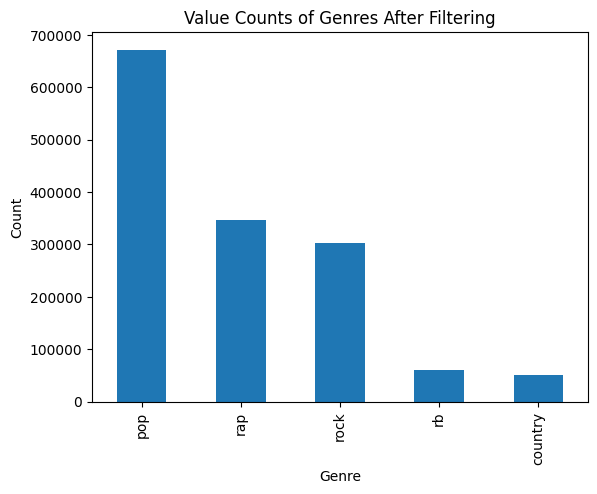

In [28]:
# Plot value counts as a bar plot
songs_filtered['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Value Counts of Genres After Filtering')
plt.xlabel('Genre')
plt.ylabel('Count')

# Display the plot
plt.show()

In [29]:
songs_filtered['tag'].value_counts()

pop        671649
rap        346573
rock       302248
rb          60218
country     51332
Name: tag, dtype: int64

## only use the top 50,000 most listened to songs for each genre

In [30]:
songs_pop = songs_filtered[songs_filtered.tag=='pop'].sort_values(by=['views'],ascending=False)
songs_rap = songs_filtered[songs_filtered.tag=='rap'].sort_values(by=['views'],ascending=False)
songs_rock = songs_filtered[songs_filtered.tag=='rock'].sort_values(by=['views'],ascending=False)
songs_rb = songs_filtered[songs_filtered.tag=='rb'].sort_values(by=['views'],ascending=False)
songs_country = songs_filtered[songs_filtered.tag=='country'].sort_values(by=['views'],ascending=False)

In [31]:
top_songs = pd.concat([songs_pop.head(50000),songs_rap.head(50000),songs_rock.head(50000),songs_rb.head(50000),songs_country.head(50000)], axis=0)

In [32]:
top_songs

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
1950930,Shape of You,pop,Ed Sheeran,2017,14569727,{},"[Verse 1]\nThe club isn't the best place to find a lover\nSo the bar is where I go\nMe and my friends at the table doing shots\nDrinking fast and then we talk slow\nAnd you come over and start up a conversation with just me\nAnd trust me I'll give it a chance now\nTake my hand, stop, put Van the Man on the jukebox\nAnd then we start to dance, and now I'm singing like\n\n[Pre-Chorus]\nGirl, you know I want your love\nYour love was handmade for somebody like me\nCome on now, follow my lead\nI ...",2949128,en,en,en
2703693,​thank u next,pop,Ariana Grande,2018,9072131,{},"[Verse 1]\nThought I'd end up with Sean\nBut he wasn't a match\nWrote some songs about Ricky\nNow I listen and laugh\nEven almost got married\nAnd for Pete, I'm so thankful\nWish I could say, ""Thank you"" to Malcolm\n'Cause he was an angel\n\n[Pre-Chorus]\nOne taught me love\nOne taught me patience\nAnd one taught me pain\nNow, I'm so amazing\nSay I've loved and I've lost\nBut that's not what I see\nSo, look what I got\nLook what you taught me\nAnd for that, I say\n[Chorus]\nThank you, next (...",4063065,en,en,en
1752512,Work,pop,Rihanna,2016,7871555,{Drake},"[Chorus: Rihanna]\nWork, work, work, work, work, work\nHe said me haffi\nWork, work, work, work, work, work\nHe see me do mi\nDirt, dirt, dirt, dirt, dirt, dirt\nSo me put in\nWork, work, work, work, work, work\nWhen you ah guh\nLearn, learn, learn, learn, learn?\nMeh nuh cyar if him\nHurt, hurt, hurt, hurt, hurting\n\n[Verse 1: Rihanna]\nDry! ...Me a desert him\nNuh time to have you lurking\nHim ah go act like he nuh like it\nYou know I dealt with you the nicest\nNuh body touch me you nuh r...",2398213,en,en,en
2153176,Too Good at Goodbyes,pop,Sam Smith,2017,7784454,{},"[Verse 1]\nYou must think that I'm stupid\nYou must think that I'm a fool\nYou must think that I'm new to this\nBut I have seen this all before\n\n[Pre-Chorus]\nI'm never gonna let you close to me\nEven though you mean the most to me\n'Cause every time I open up, it hurts\nSo I'm never gonna get too close to you\nEven when I mean the most to you\nIn case you go and leave me in the dirt\n\n[Chorus]\nBut every time you hurt me, the less that I cry\nAnd every time you leave me, the quicker thes...",3219597,en,en,en
2706746,7 rings,pop,Ariana Grande,2019,7387794,{},"[Verse 1]\nYeah, breakfast at Tiffany's and bottles of bubbles\nGirls with tattoos who like getting in trouble\nLashes and diamonds, ATM machines\nBuy myself all of my favorite things (Yeah)\nBeen through some bad shit, I should be a sad bitch\nWho woulda thought it'd turn me to a savage?\nRather be tied up with calls and not strings\nWrite my own checks like I write what I sing, yeah (Yeah)\n\n[Pre-Chorus]\nMy wrist, stop watchin', my neck is flossy\nMake big deposits, my gloss is poppin'\n...",4067762,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
3614037,Georgia On My Mind,country,Tony Rice,1975,50,{},"Georgia, Georgia, the whole day through\nAn' just an old sweet song keeps Georgia on my mind\nGeorgia, Georgia, a song of you\nComes as sweet and clear as moonlight through the pines\nOther arms reach out to me\nOther eyes smile tenderly\nStill in peaceful dreams I see\nThe road leads back to you\nGeorgia, Georgia, no peace I find\nJust an old sweet song keeps Georgia on my mind\nGeorgia, Georgia, no peace I find\nJust an old sweet song keeps Georgia on my mind\nJust an old sweet song keeps ...",5462856,en,en,en
1100406,Please Help Me I’m Falling,country,Wanda Jackson,1964,50,{},"Please help me, I'm falling in love with you\nClose the door to temptation, don't let me walk through\nTurn away from me, darling, I'm begging you to\nPlease help me, I'm falling in love with you\n\nI belong to another whose arms have grown cold\nBut I promised forever to have and to hold\nI can never be free, dear, but when I'm with you\nI know that I'm losing 

In [33]:
top_songs.to_csv('top_songs.csv')

## Clean and Tokenize the text

In [ ]:
import re
top_songs['lyrics_cleaned'] = top_songs['lyrics'].apply(lambda x: re.sub(r'\[[^\]]*\]', '', x))
top_songs['lyrics_cleaned'] = top_songs['lyrics_cleaned'].apply(lambda x: re.sub(r'\n', ' ', x))

In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_list = top_songs['lyrics_cleaned'].tolist()

In [ ]:
data_tokens = list(sent_to_words(data_list))

In [ ]:
%%time
import spacy

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [109]:
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

In [113]:
data_lemmatized = lemmatization(data_tokens_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [114]:
top_songs['data_tokenized'] = data_lemmatized

In [115]:
top_songs.to_csv('top_songs_tokens.csv')

## Check Song Lengths and get rid of songs that are too long or too short

In [126]:
top_songs['num_tokens'] = top_songs['data_tokenized'].apply(lambda x: len(x))

In [127]:
top_songs.sort_values(by=['num_tokens'])

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,lyrics_cleaned,data_tokenized,num_tokens
1650075,Nangs,rock,Tame Impala,2015,123859,{},[Interlude]\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut...,2165812,en,en,en,But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more...,[],0
216670,Over,rock,A Perfect Circle,2000,5552,{},Been over\nBeen over this before\nBeen over and over\nBeen over this before\n\nAnd over\nBeen over this before\n\nSo over this\nBeen over this\nSo over this\nBeen over this\nOver this before,253848,en,en,en,Been over Been over this before Been over and over Been over this before And over Been over this before So over this Been over this So over this Been over this Over this before,[],0
2297077,​xx,pop,Hayley Kiyoko,2018,17636,{},"[Intro]\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nYeah, yeah\nYeah, yeah\nWhy'd you do that?",3444425,en,en,en,"Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Yeah, yeah Yeah, yeah Why'd you do that?",[],0
2199622,Backwater,rb,Kllo,2017,911,{},"No, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now",3281892,en,en,en,"No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now",[],0
469192,Marvin Interlude,rb,Mary J. Blige,1994,1020,{},"[Verse]\nOh, oh, you know that I\nYou know that I want to be with you, with you\nI just wanna be with you\nOh, oh, ooh, oh, oh, oh, oh, oh, oh, oh",765778,en,en,en,"Oh, oh, you know that I You know that I want to be with you, with you I just wanna be with you Oh, oh, ooh, oh, oh, oh, oh, oh, oh, oh",[want],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555690,Rolling 110 Deep,rap,DJ Kay Slay,2021,53438,"{""Ghostface Killah"",Twista,""Styles P"",Raekwon,""Jim Jones"",AZ,""Black Thought"",""Sauce Money"",""Big Daddy Kane"",Redman,Cassidy,""Sheek Louch"",""Joell Ortiz"",""Bun B"",""J.R. Writer"",Consequence,""Cory Gunz"",""MC Shan"",""Young Buck"",""KXNG Crooked"",""Uncle Murda"",""Inspectah Deck"",McGruff,""Loaded Lux"",Saigon,Locksmith,Vado,""Stan Spit"",""K

In [131]:
top_songs.num_tokens.quantile(.05)

40.0

In [136]:
top_songs.num_tokens.quantile(.98)

335.0

In [137]:
top_songs_final = top_songs[(top_songs.num_tokens<335) & (top_songs.num_tokens>40)]

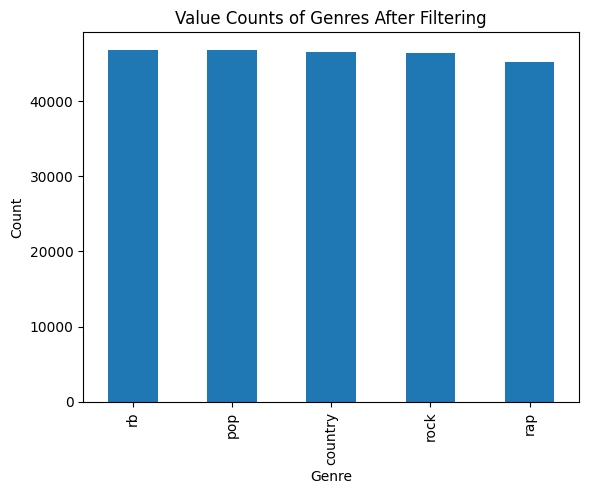

In [138]:
# Plot value counts as a bar plot
top_songs_final['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Value Counts of Genres After Filtering')
plt.xlabel('Genre')b
plt.ylabel('Count')

# Display the plot
plt.show()

In [139]:
top_songs_final.to_csv('top_songs_final.csv')

In [2]:
from google.cloud import storage
import os
import io
client = storage.Client()
bucket = client.get_bucket('nlp_final_data')

In [3]:
blob = bucket.blob('top_songs_final.csv')
blob.upload_from_filename('top_songs_final.csv')

## Most Common Words by Song Genre

In [34]:
blob = bucket.blob('top_songs_final.csv')
content = blob.download_as_string()

songs = pd.read_csv(io.BytesIO(content))

In [35]:
songs['data_tokenized'] = songs['data_tokenized'].apply(lambda x: x.strip('[]').replace('\'', '').split(', '))

In [38]:
songs['data_tokenized'] = songs['data_tokenized'].apply(lambda x: [word.strip() for word in x])

## R&B 

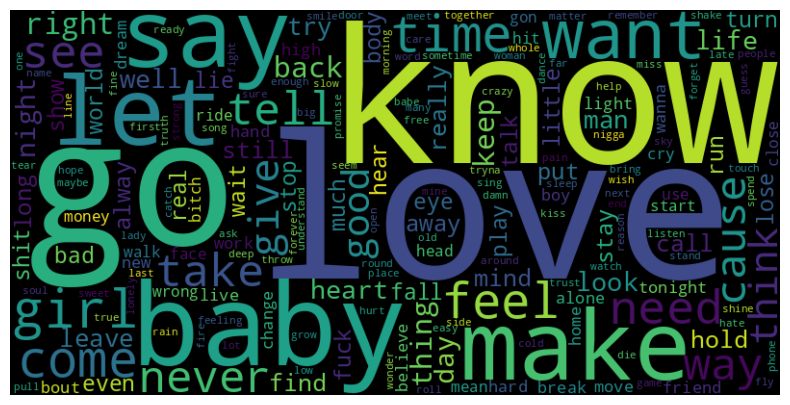

In [40]:
all_rb = ' '.join([word for sublist in songs[songs['tag']=='rb']['data_tokenized'] for word in sublist])

wordcloud = WordCloud(width=800, height=400,collocations = False).generate(all_rb)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rock 

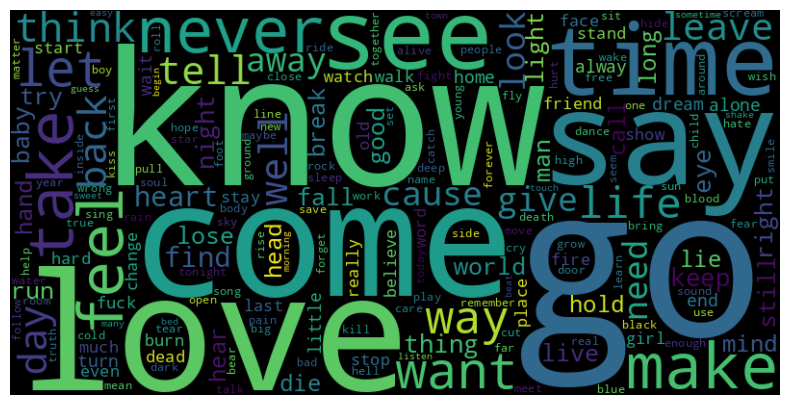

In [42]:
all_rock = ' '.join([word for sublist in songs[songs['tag']=='rock']['data_tokenized'] for word in sublist])

wordcloud = WordCloud(width=800, height=400,collocations = False).generate(all_rock)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Pop

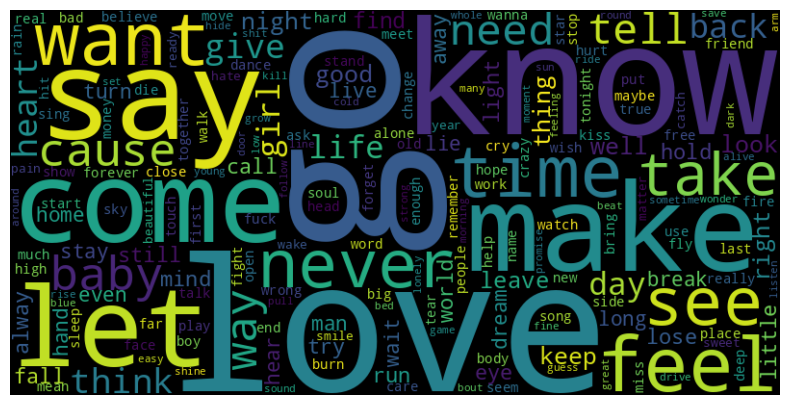

In [43]:
all_pop = ' '.join([word for sublist in songs[songs['tag']=='pop']['data_tokenized'] for word in sublist])

wordcloud = WordCloud(width=800, height=400,collocations = False).generate(all_pop)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rap

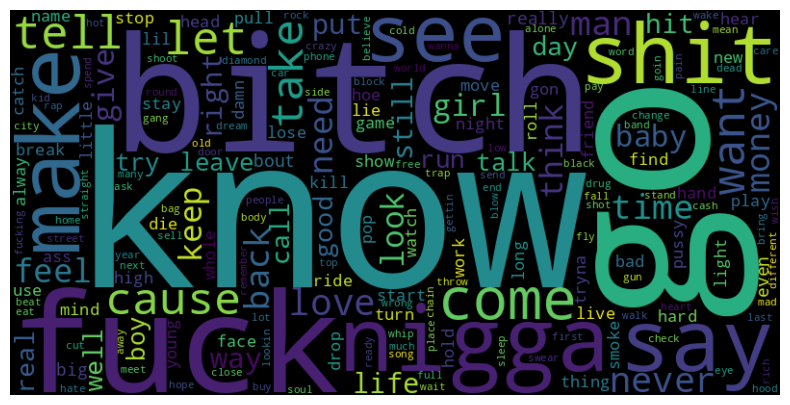

In [44]:
all_rap = ' '.join([word for sublist in songs[songs['tag']=='rap']['data_tokenized'] for word in sublist])

wordcloud = WordCloud(width=800, height=400,collocations = False).generate(all_rap)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Country

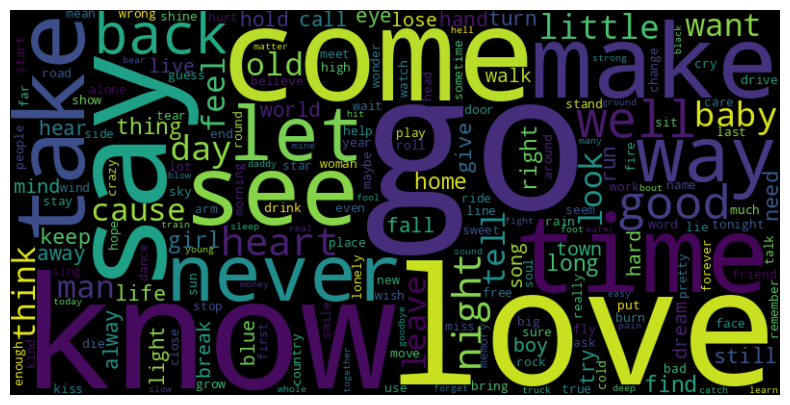

In [46]:
all_count = ' '.join([word for sublist in songs[songs['tag']=='country']['data_tokenized'] for word in sublist])

wordcloud = WordCloud(width=800, height=400,collocations = False).generate(all_count)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Create Model

In [140]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM,Dense,Dropout, Reshape, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from tensorflow.keras.optimizers import Adam

from gensim.models import Word2Vec

In [141]:
X = top_songs_final['data_tokenized']
y = top_songs_final['tag']

In [142]:
# split the balanced data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2,stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [143]:
tokenize = Tokenizer(char_level=False)
tokenize.fit_on_texts(X) # only fit on train

# we will need this later
num_words = len(tokenize.word_index)+1

In [144]:
num_words

106895

In [145]:
x_train = tokenize.texts_to_sequences(X_train)
x_test = tokenize.texts_to_sequences(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [146]:
max_len = 0
for song in x_train:
    if len(song)>max_len:
        max_len = len(song)

In [147]:
max_log_length = max_len
x_train = pad_sequences(x_train, maxlen=max_log_length)
x_test = pad_sequences(x_test, maxlen=max_log_length)

In [162]:
model3 = Sequential()

model3.add(Embedding(input_dim=num_words,output_dim=64,input_length=max_log_length))

num_filters = 128
kernel_sizes = [2,3]
for kernel_size in kernel_sizes:
    model3.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#model3.add(Conv1D(128, 3, activation='relu'))


model3.add(LSTM(units=64,recurrent_dropout=0.5))
model3.add(Dropout(0.5))

# Add Dense layers
hidden_units = [128,64]
for units in hidden_units:
    model3.add(Dense(units, activation='relu'))
    model3.add(Dropout(0.5))
    
model3.add(Dense(num_classes,activation='softmax'))

# compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [152]:
history = model3.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
1305/1305 [==============================] - 218s 165ms/step - loss: 1.2153 - accuracy: 0.4757 - val_loss: 1.0410 - val_accuracy: 0.5731
Epoch 2/10
1305/1305 [==============================] - 210s 161ms/step - loss: 1.0215 - accuracy: 0.5952 - val_loss: 1.0017 - val_accuracy: 0.5974
Epoch 3/10
1305/1305 [==============================] - 210s 161ms/step - loss: 0.9312 - accuracy: 0.6364 - val_loss: 1.0199 - val_accuracy: 0.5958
Epoch 4/10
1305/1305 [==============================] - 209s 160ms/step - loss: 0.8506 - accuracy: 0.6743 - val_loss: 1.0558 - val_accuracy: 0.5804
Epoch 5/10
1305/1305 [==============================] - 207s 159ms/step - loss: 0.7672 - accuracy: 0.7116 - val_loss: 1.1595 - val_accuracy: 0.5813
Epoch 6/10
1305/1305 [==============================] - 208s 160ms/step - loss: 0.6788 - accuracy: 0.7489 - val_loss: 1.2094 - val_accuracy: 0.5776
Epoch 7/10
1305/1305 [==============================] - 208s 159ms/step - loss: 0.5955 - accuracy: 0.7829 - val_

In [150]:
model3.save('model_top_songs.h5')

In [158]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['accuracy'], 'go', label='Training acc')
    plt.plot(epochs, h['val_accuracy'], 'g', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

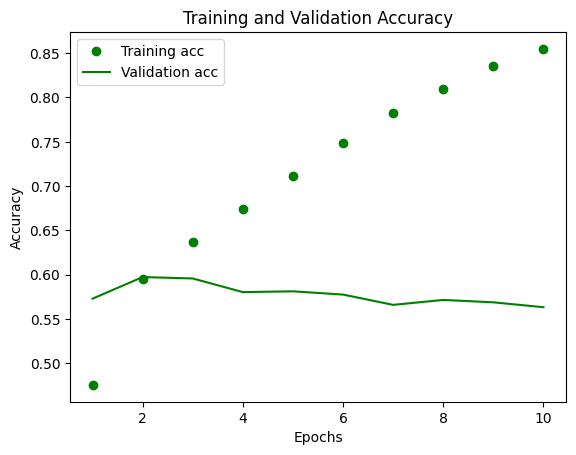

In [159]:
plot_train(history)

In [63]:
bucket_name = 'nlp_final_data'

def write_to_blob(bucket_name,filename,data):
    with open(data, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filename)
    blob.upload_from_filename(filename)

In [78]:
write_to_blob(bucket_name,'songs_filtered.csv',songs_filtered)

TypeError: expected str, bytes or os.PathLike object, not DataFrame

In [23]:
songs_noMIsc.tag.value_counts()

pop        1393559
rap         964605
rock        633308
rb          155082
country      86658
Name: tag, dtype: int64

In [27]:
len(sampled_df)

433290

In [35]:
sampled_df.to_csv('songs_even_sample.csv')

In [ ]:
write_to_blob(bucket_name,'data_even_sample.csv',sampled_df)